# Defacing pre-registration - Statistical analysis in R

In [49]:
# Helper function to diagnose linear mixed-effects model fit
visualize_lmer_fit <- function(model, defaced=FALSE){
    # Install and load necessary packages
    library(lme4)
    library(ggplot2)
    library(gridExtra)
    library(ggpubr)

    #Plot size
    options(repr.plot.width=20, repr.plot.height=10)

    # Extract residuals and fitted values
    residuals <- residuals(model)
    fitted_values <- fitted(model)

    # Extract random effects
    random_effects_list <- ranef(model)

    # Residuals vs Fitted Values plot
    residuals_plot <- ggplot(data = data.frame(Fitted = fitted_values, Residuals = residuals),
                            aes(x = Fitted, y = Residuals)) +
        geom_point() +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        theme(text = element_text(size = 36))+
        theme_minimal() +
        labs(title = "Residuals vs Fitted Values",
            x = "Fitted Values",
            y = "Residuals")
    

    # QQ plot of residuals
    qq_plot_residuals <- ggqqplot(residuals) +
        theme(text = element_text(size = 36))+
        theme_minimal() +
        labs(title = "Residuals vs Fitted Values",
            x = "Fitted Values",
            y = "Residuals")

    # List to store QQ plots for random effects
    qq_plots_random_effects <- list()
    
    # Generate QQ plots for each random effect
    for (re in names(random_effects_list)) {
        random_effects <- unlist(random_effects_list[[re]])
        qq_plot <- ggqqplot(random_effects) +
            theme(text = element_text(size = 36))+
            theme_minimal() +
            labs(title = paste("QQ Plot of Random Effects:", re),
                x = "Theoretical Quantiles",
                y = "Sample Quantiles")
            qq_plots_random_effects[[re]] <- qq_plot
    }
  
    # Combine all plots into a single figure
    combined_plots <- list(residuals_plot, qq_plot_residuals)
    combined_plots <- c(combined_plots, qq_plots_random_effects)
    combined_plot <- do.call(grid.arrange, c(combined_plots, ncol = 2))

    # Print the combined plot
    print(combined_plot)
}


## Load the simulated or collected manual ratings

In [50]:
df <- read.csv(file = '../../data/IXI_augmented_ratings_df.tsv', sep='\t')
# Drop columns we will not use in the analysis
df <- df[, !names(df) %in% c("dataset", "artifacts", "time_sec", "confidence", "comments", "randomized_id")]
# sort dataframe by subject ID
df <- df[order(df$subject),]
df

,rater_id,rating,defaced,subject
,<chr>,<dbl>,<int>,<int>
49,rater_03,3.45,0,12
100,rater_01,3.40,0,12
134,rater_04,3.50,0,12
192,rater_02,3.65,0,12
787,rater_04,3.90,1,12
1038,rater_02,3.50,1,12
1410,rater_03,2.75,1,12
1659,rater_01,3.40,1,12
180,rater_04,3.45,0,13


In [51]:
library(dplyr)
# When there are two ratings corresponding to one image, keep first rating only, as rm-ANOVA is not able to deal with duplicates
df_nodup <- df[!duplicated(df[c("subject", "defaced", "rater_id")]), ]
nrow(df_nodup)

[1] 1480

## Linear mixed-effects models

We will test if including the defacing factor as fixed effect improves the model fit using a likelihood-ratio test.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_nodup

     AIC      BIC   logLik deviance df.resid 
  1546.8   1568.0   -769.4   1538.8     1476 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3693 -0.5709  0.0442  0.6422  3.4396 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.14729  0.3838  
 rater_id (Intercept) 0.04958  0.2227  
 Residual             0.12169  0.3488  
Number of obs: 1480, groups:  subject, 185; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)   3.1242     0.1152   27.12

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


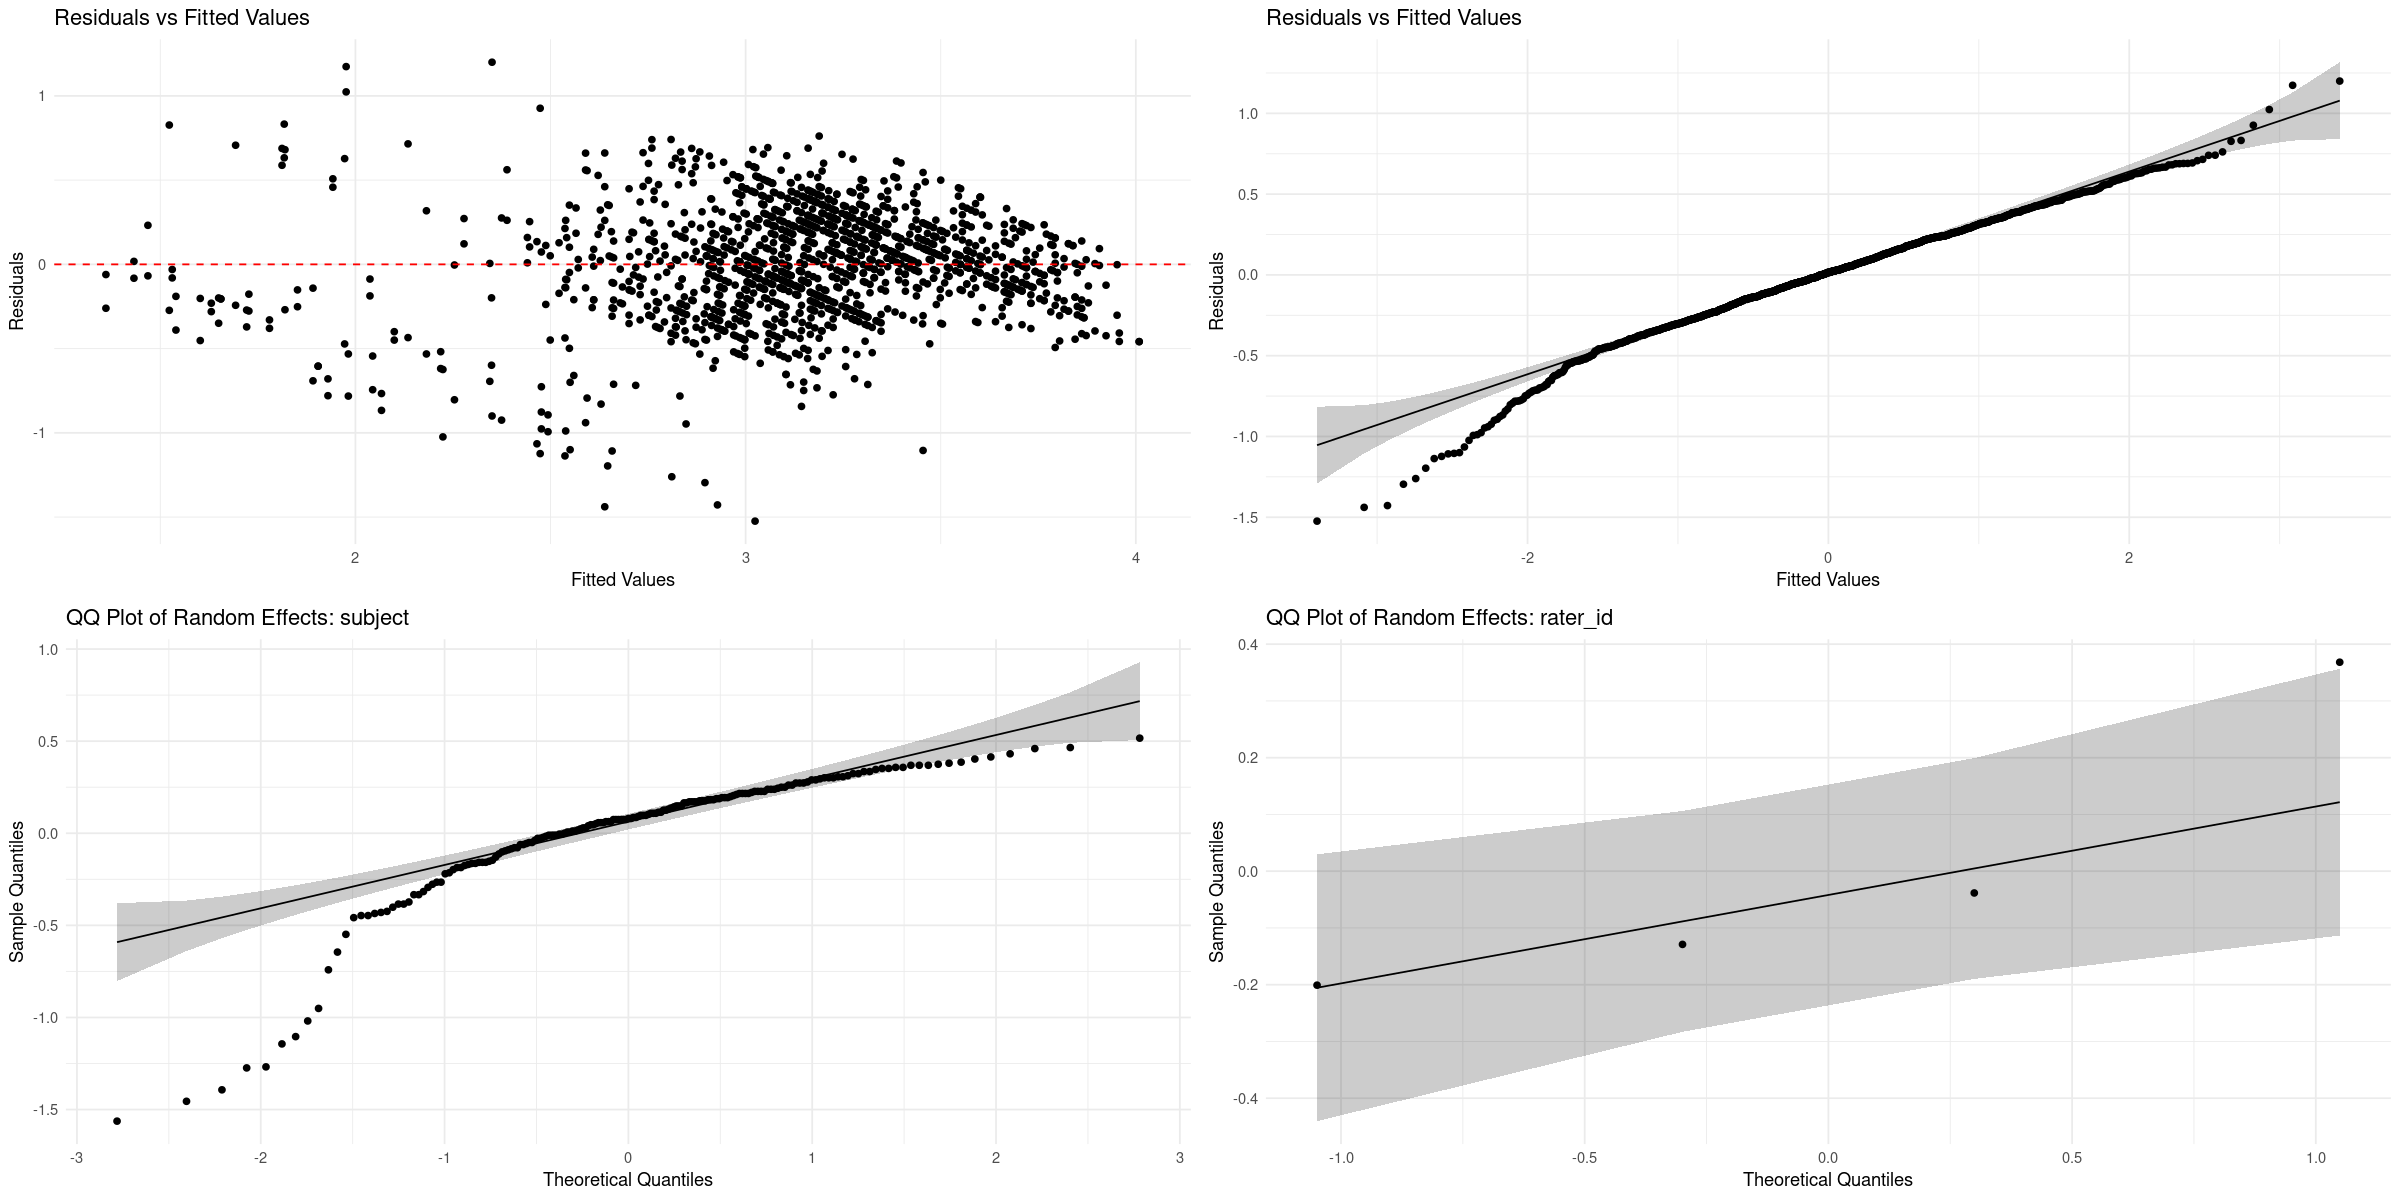

In [52]:
## Fit model without including defaced
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_nodup, REML=FALSE)
summary(fm0)
suppressWarnings(visualize_lmer_fit(fm0))


TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


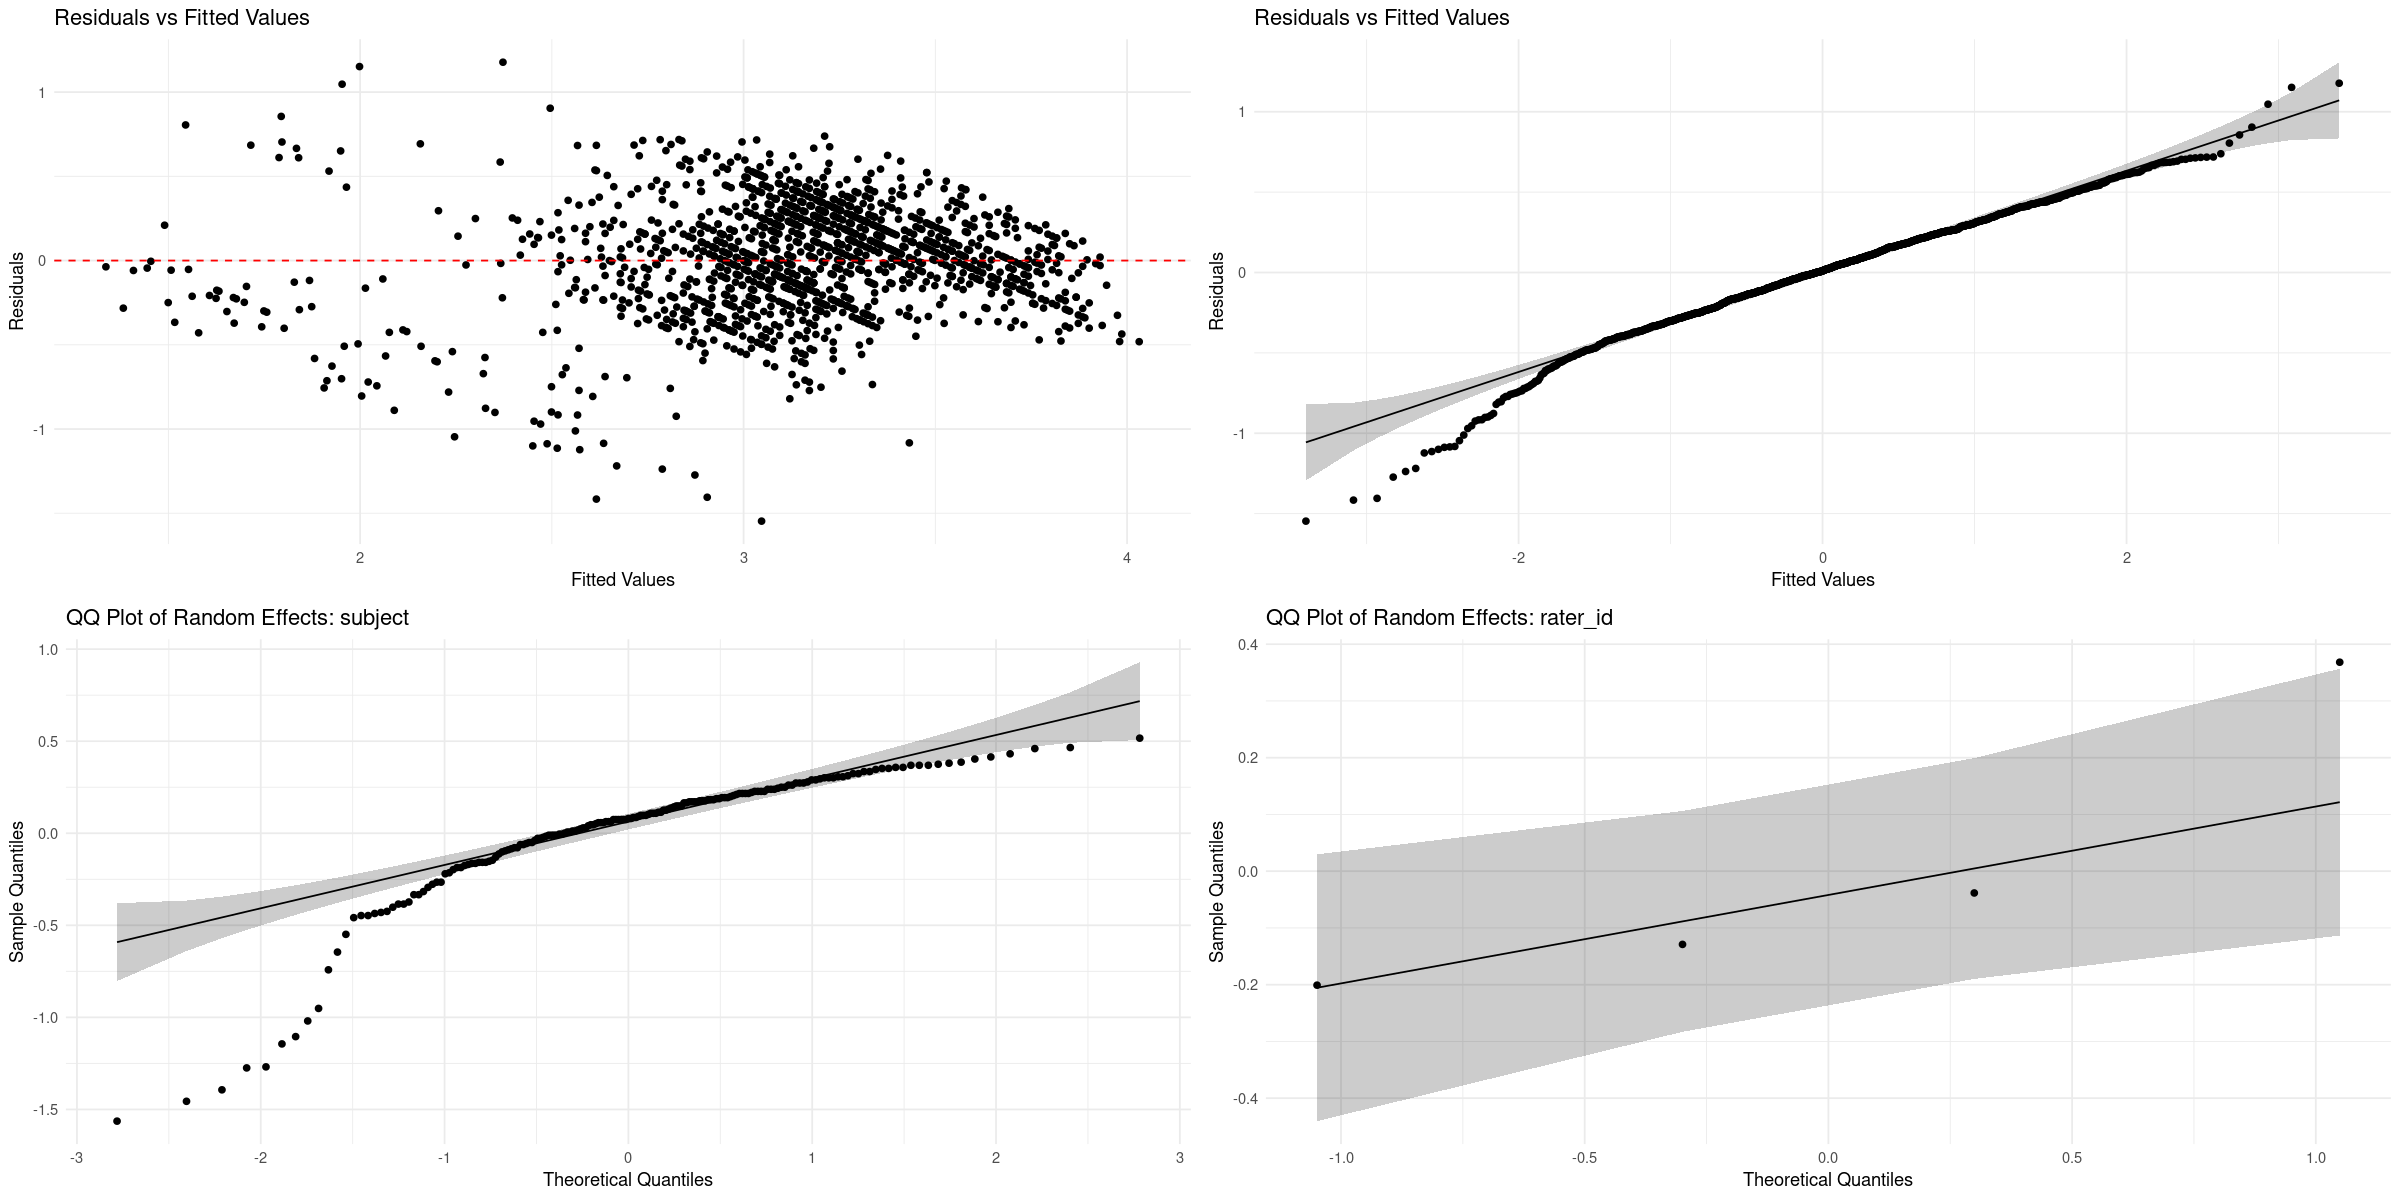

In [53]:
## Fit model including defaced
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id) , data=df_nodup, REML=FALSE)
suppressWarnings(visualize_lmer_fit(fm1))

In [54]:
#Likelihood-ratio test
anova(fm0, fm1)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,1546.788,1567.987,-769.3938,1538.788,NA,NA,NA
fm1,5,1542.504,1569.003,-766.2520,1532.504,6.283544,1,0.01218642


The p-value for the likelihood-ratio test is significant (3e-8) meaning that defacing influence on the manual ratings is significant.

## Exploratory analysis


### Linear mixed-effects without rater_04

In [55]:
#Remove rater_04
df_nodup_w04 <- df_nodup %>%
  filter(rater_id != "rater_04")
nrow(df_nodup_w04)

[1] 1110

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_nodup_w04

     AIC      BIC   logLik deviance df.resid 
  1326.1   1346.2   -659.1   1318.1     1106 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8200 -0.5850  0.0382  0.6406  3.1009 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.156950 0.39617 
 rater_id (Intercept) 0.004675 0.06837 
 Residual             0.135069 0.36752 
Number of obs: 1110, groups:  subject, 185; rater_id, 3

Fixed effects:
            Estimate Std. Error t value
(Intercept)  3.00063    0.05028   59.67

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


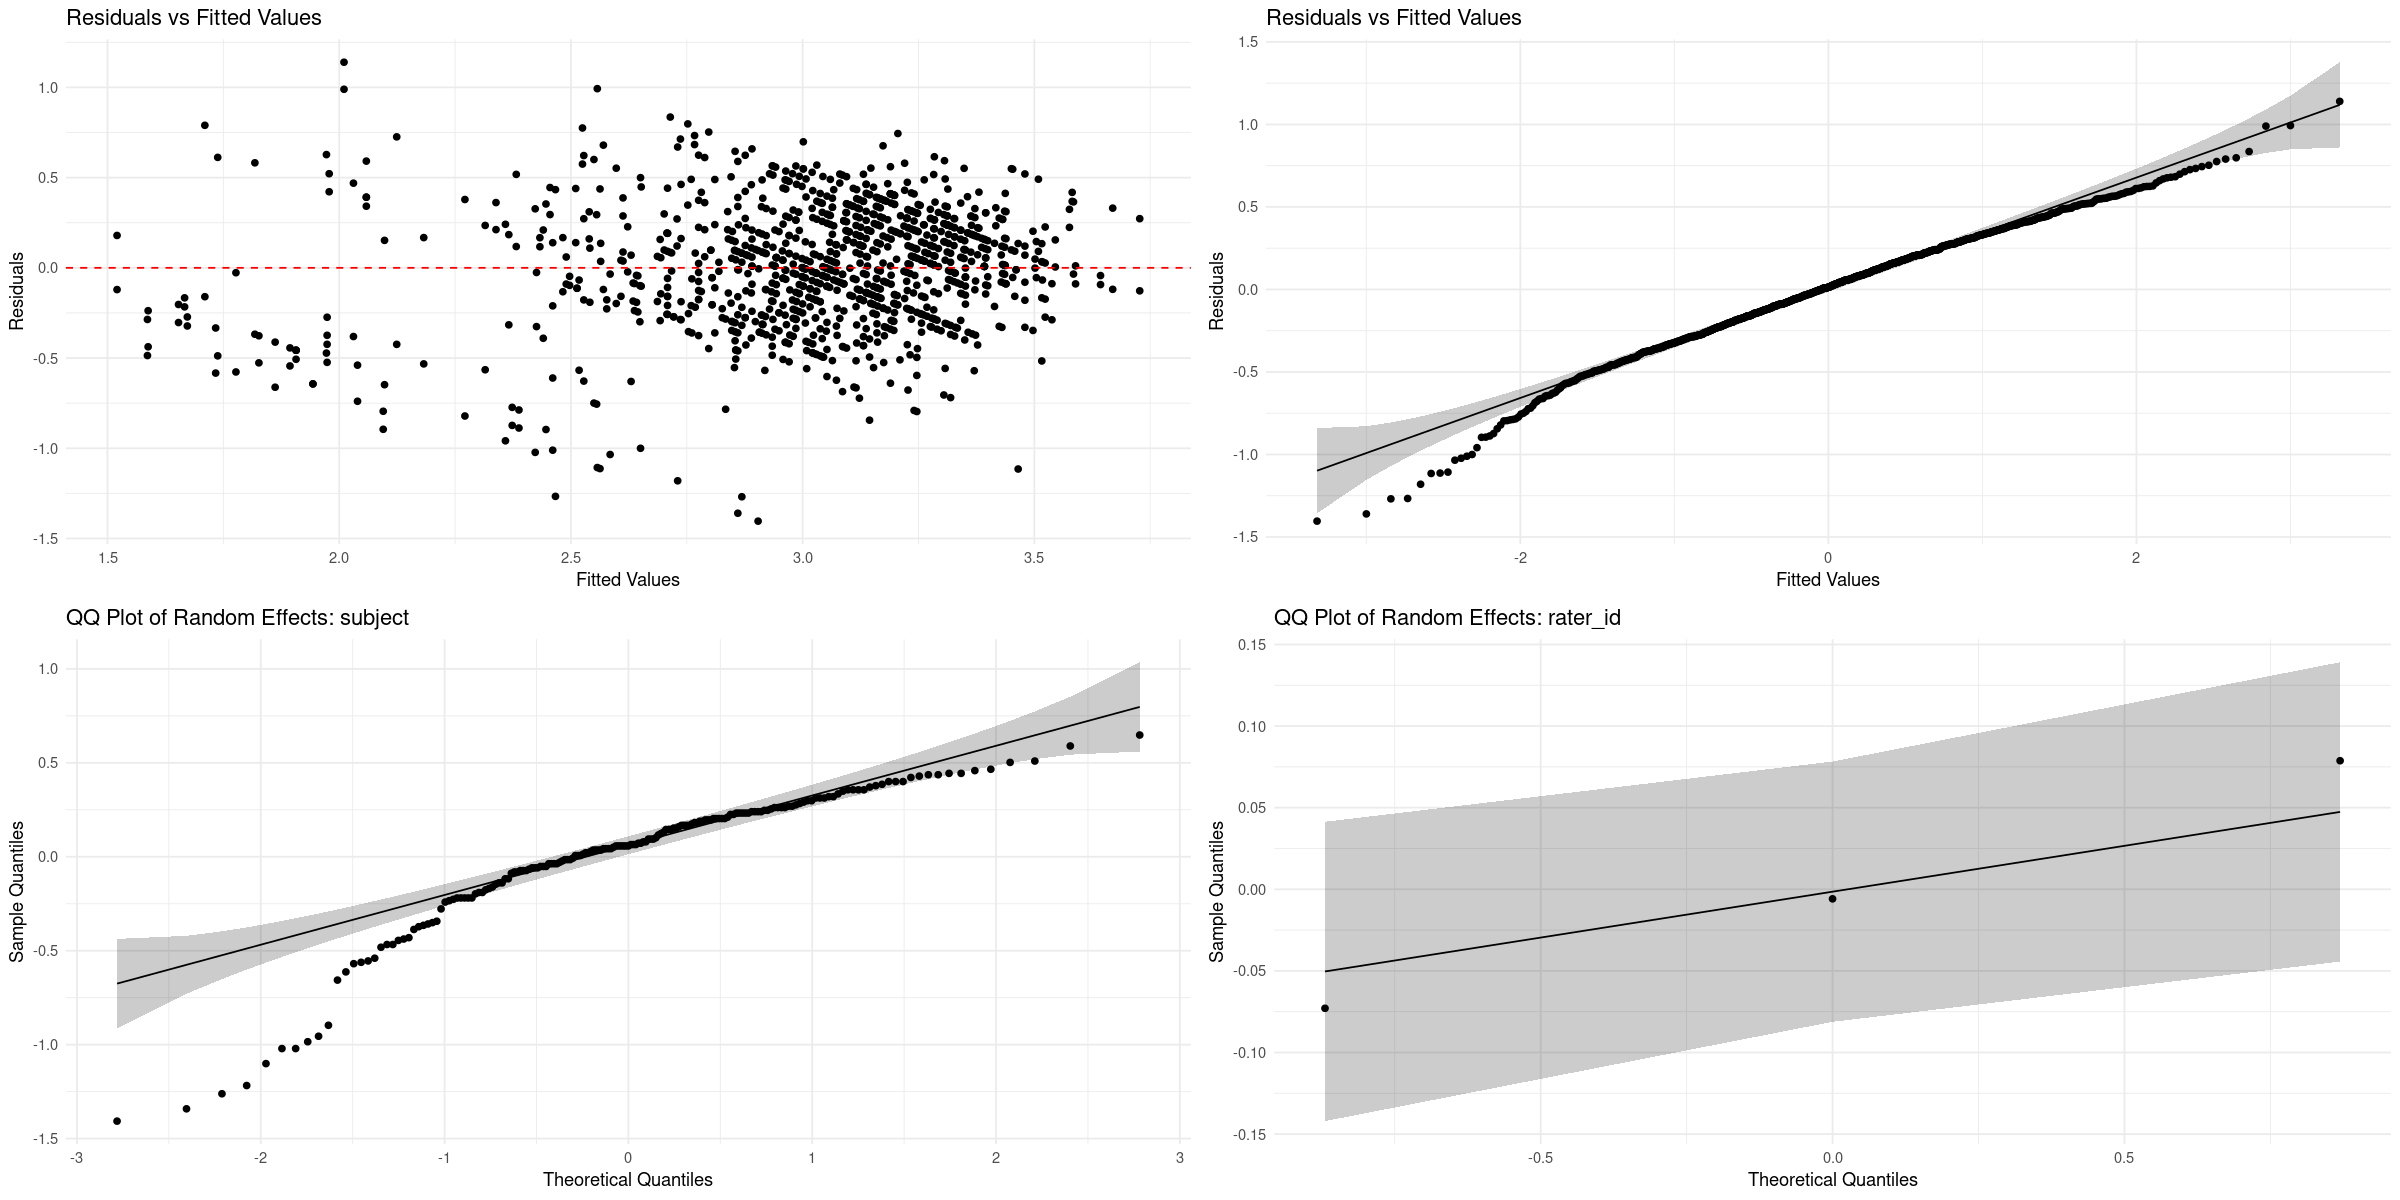

In [56]:
## Fit model without including defaced
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_nodup_w04, REML=FALSE)
summary(fm0)
suppressWarnings(visualize_lmer_fit(fm0))


TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


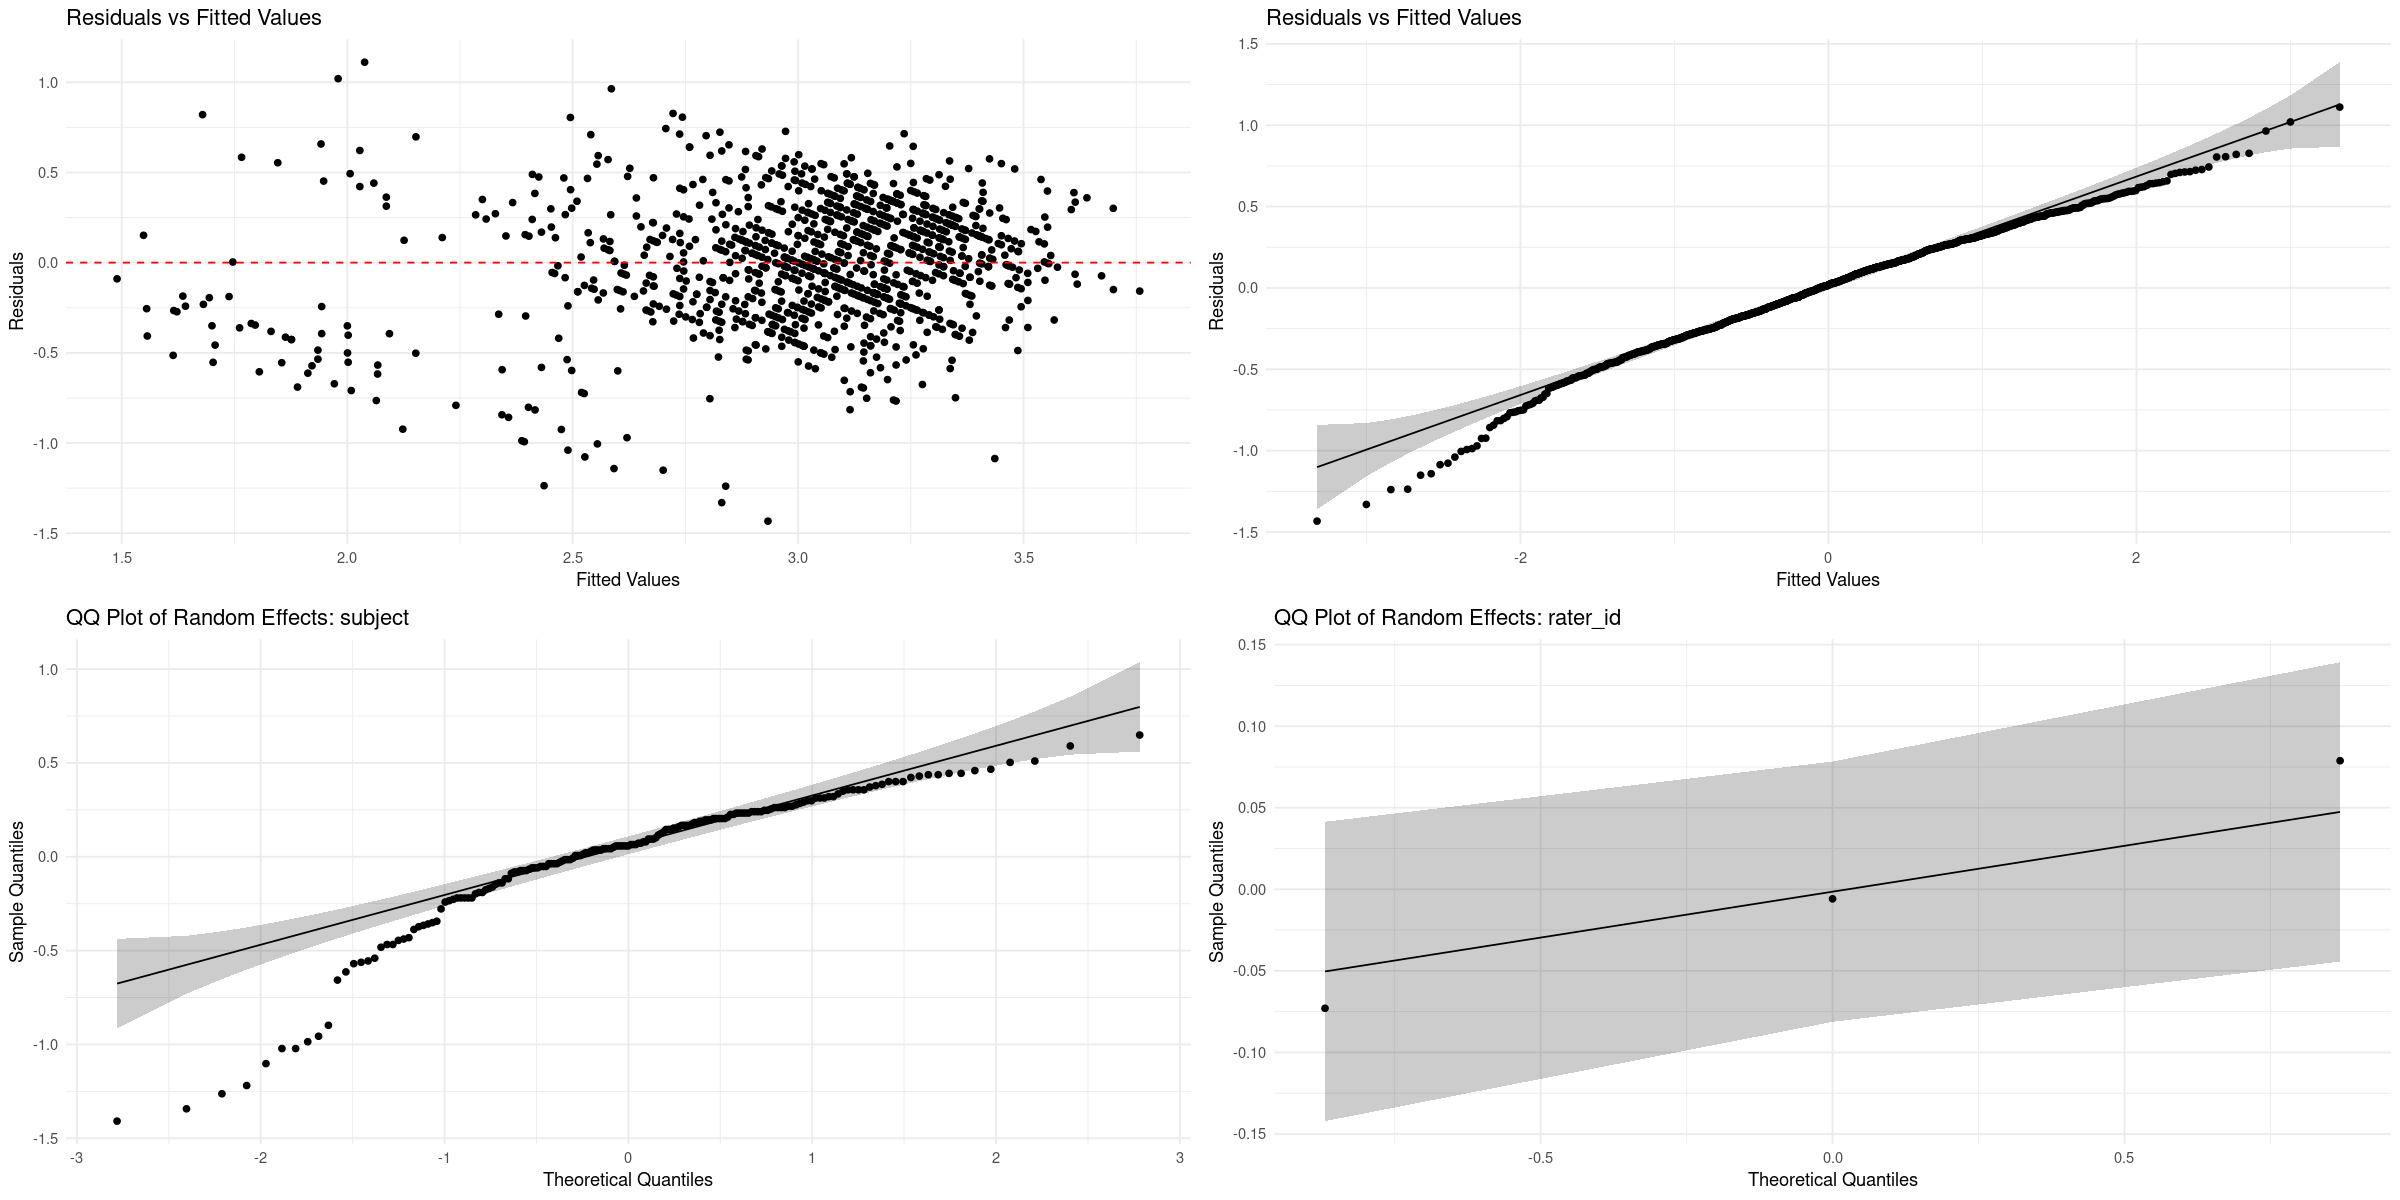

In [57]:
## Fit model including defaced
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id), data=df_nodup_w04, REML=FALSE)
suppressWarnings(visualize_lmer_fit(fm1))

In [58]:
#Likelihood-ratio test
anova(fm0, fm1)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,1326.116,1346.164,-659.0578,1318.116,NA,NA,NA
fm1,5,1321.000,1346.060,-655.4998,1311.000,7.115882,1,0.007640401


### Linear mixed-effects with only poor quality and excluded scans

In [59]:
library(dplyr)
df_poor <- df %>%
  filter(rating <= 2.45)
nrow(df_poor)

[1] 186

Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_poor

REML criterion at convergence: 193.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2169 -0.6559  0.1103  0.5891  2.3674 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.10563  0.3250  
 rater_id (Intercept) 0.01268  0.1126  
 Residual             0.10662  0.3265  
Number of obs: 186, groups:  subject, 63; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.09352    0.07723   27.11

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


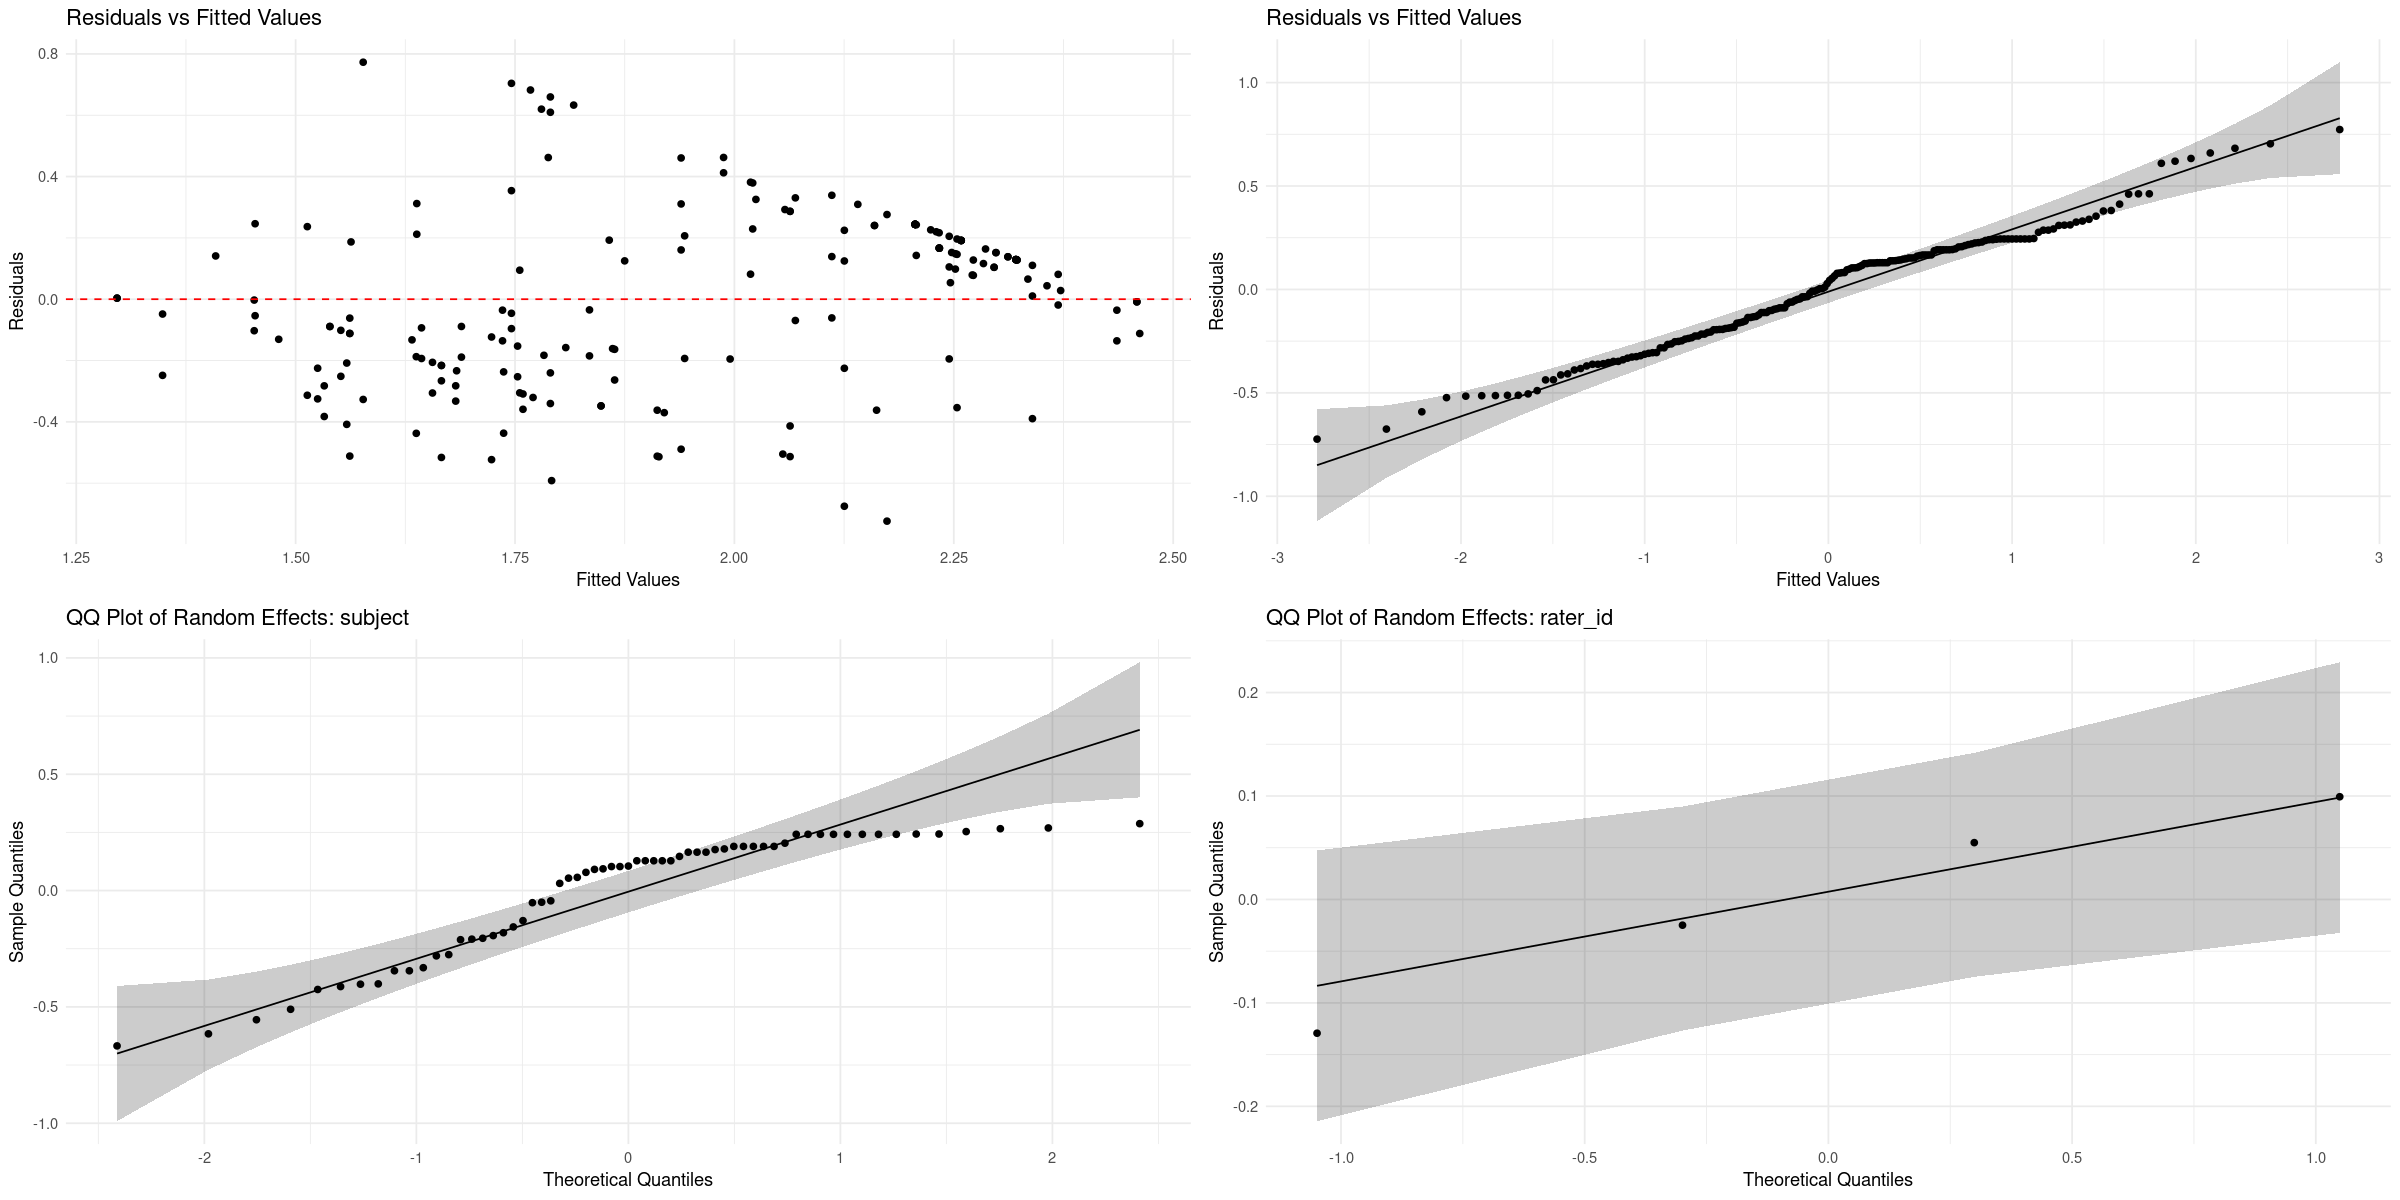

In [60]:
## Fit model without defaced as random effect
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_poor)
summary(fm0)
suppressWarnings(visualize_lmer_fit(fm0))

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


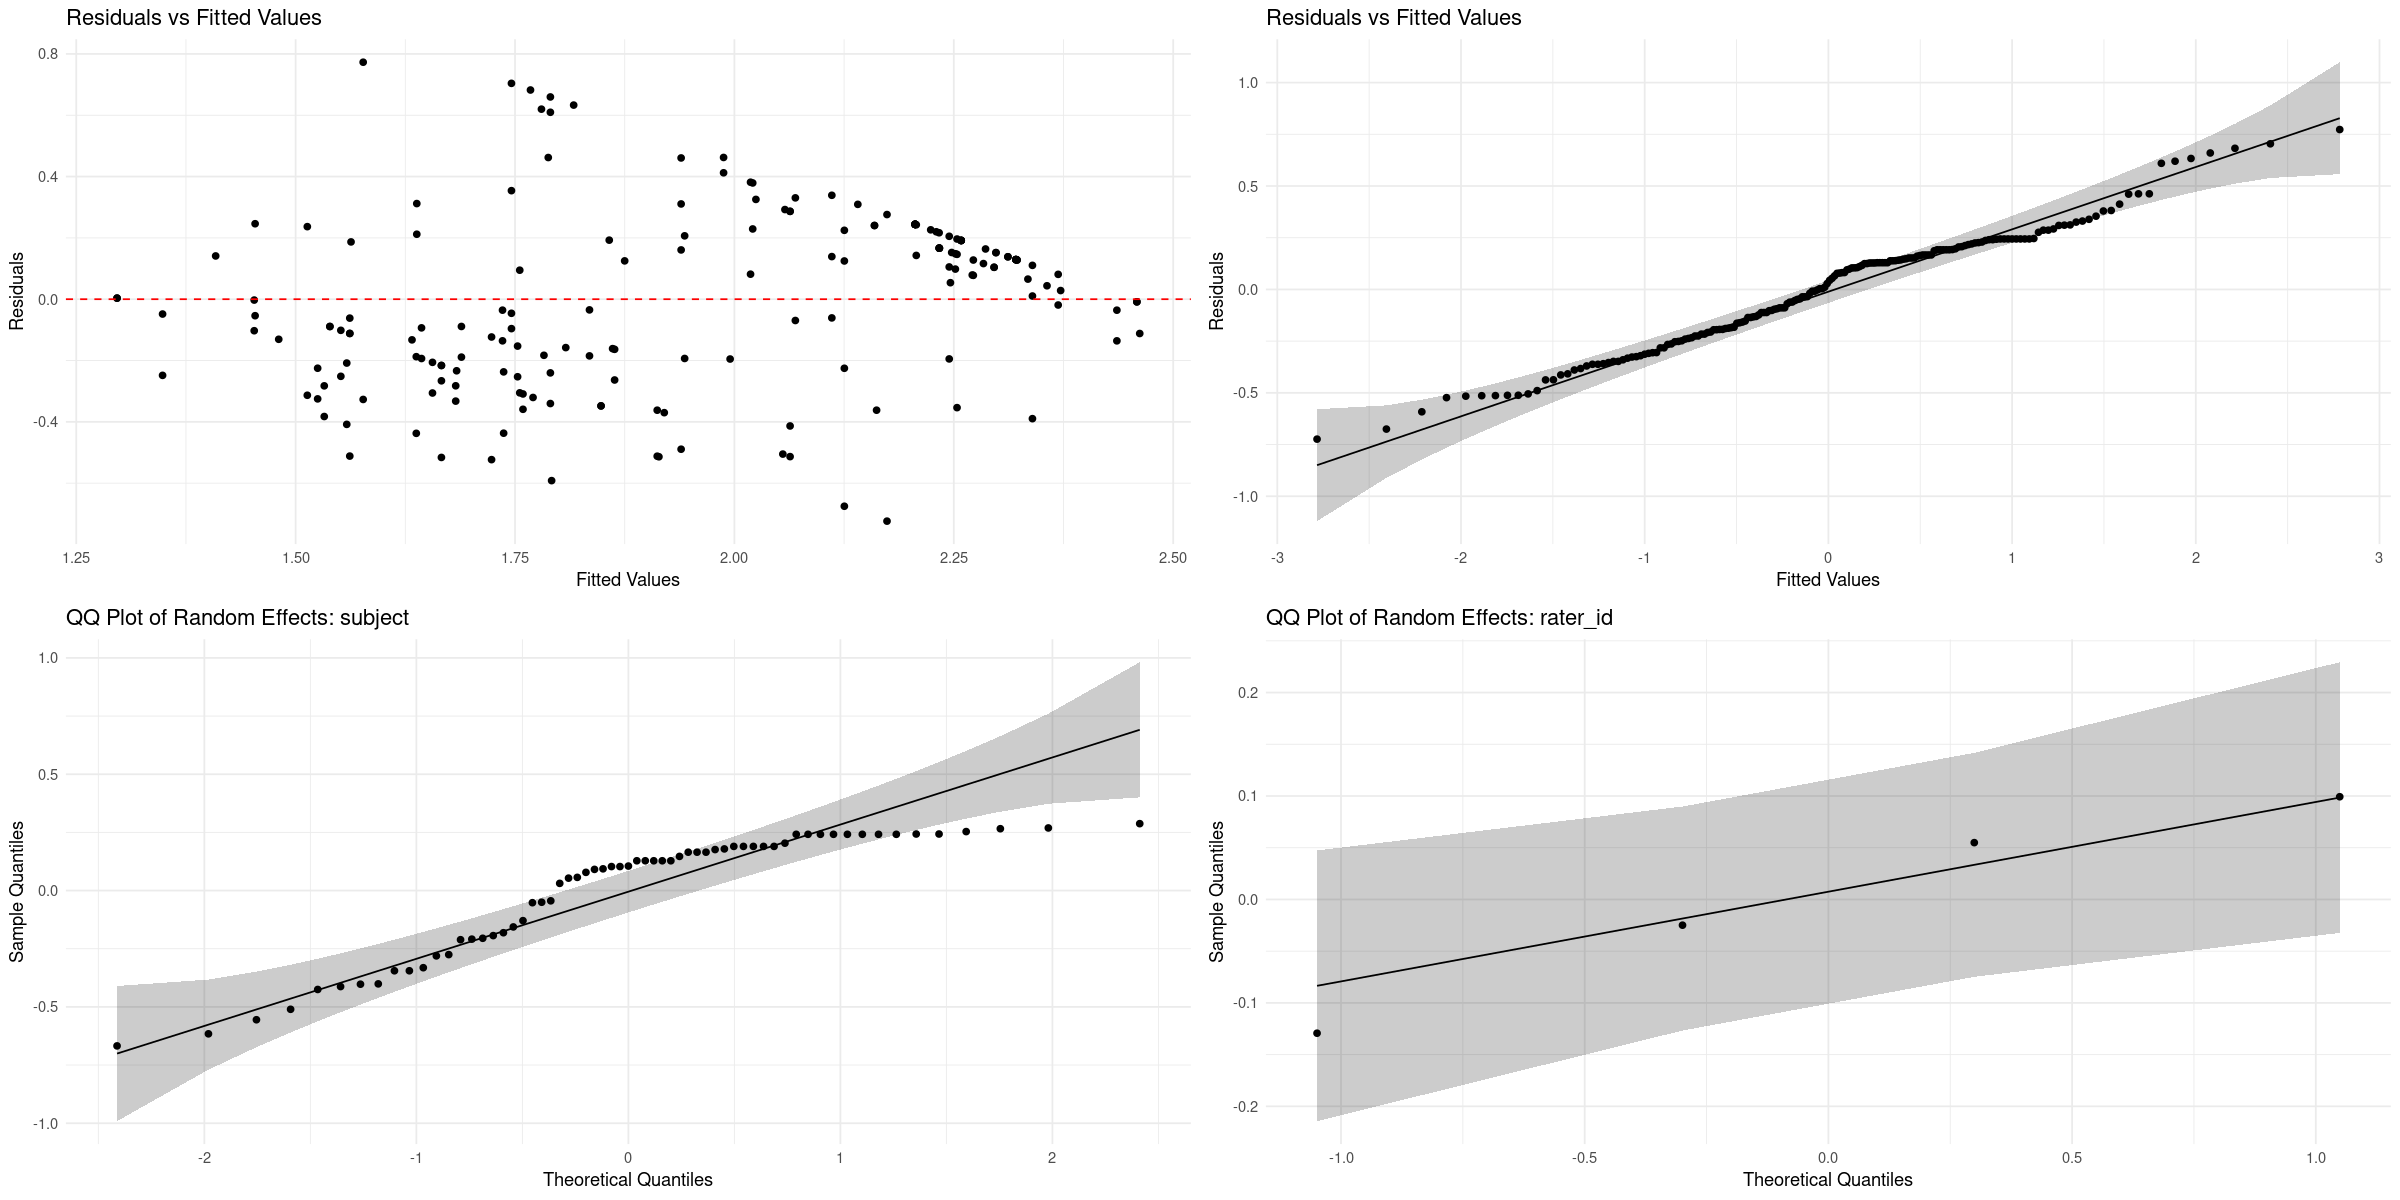

In [61]:
## Fit model with defaced as random effect
library(lme4)
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id), data=df_poor)
suppressWarnings(visualize_lmer_fit(fm0))

In [62]:
#Likelihood-ratio test
anova(fm0, fm1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,198.5114,211.4144,-95.25569,190.5114,NA,NA,NA
fm1,5,192.4623,208.5911,-91.23116,182.4623,8.049064,1,0.004552716


## Sanity check with simulated data

We verify that the model selected is able to detect differences when a bias has been manually introduced in simulated data and vice versa that the model does not detect differences when no bias was introduced. The simulated data were generated by running `../../data/simulate_data.R`

In [63]:
library(lme4)
# Load simulated data
simulated_df <- readRDS(("../../data/simulated_normal_ratings.rds"))

#Fit the models
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=simulated_df)
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id), data=simulated_df)

#Likelihood-ratio test
anova(fm0, fm1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,11136.61,11157.81,-5564.305,11128.61,NA,NA,NA
fm1,5,11070.52,11097.02,-5530.262,11060.52,68.08651,1,1.564776e-16


All good, we see that the simulated bias is detected by our linear mixed-effects model.

In [64]:
library(lme4)
# Load the simulated data without bias
simulated_df_no_bias <- readRDS(("../../data/simulated_normal_nobias_ratings.rds"))

#Fit the models
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=simulated_df_no_bias)
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id), data=simulated_df_no_bias)

#Likelihood-ratio test
anova(fm0, fm1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,10937.58,10958.78,-5464.792,10929.58,NA,NA,NA
fm1,5,10939.54,10966.04,-5464.771,10929.54,0.04041613,1,0.8406691


We also verified that no bias is found by our models when it is not introduced in the simulated data.